# protostars
## 27 - Synthetic JWST data
### part I- simulate

In [1]:
import pandas as pd

From the protostar writeup:

- NIRSPEC IFU with the G235M grating
- $1.7 - 3.0 \; \mu$m
- $R\sim 1000$
- $S/N \sim100$

That's enough to simulate the spectrum!  
(ideally, we'd want some wavelength dependent $S/N$, wavelength-dependent spectral resolution, and any gaps).

Howe et al. 2017 has done a similar job here:  
https://arxiv.org/pdf/1612.01245.pdf

They even provide the wavelength dependent spectral resolution.  That's nice!

In [2]:
#Convert R to FWHM in km/s by \Delta v = c/R
import astropy.constants as C

import astropy.units as u

In [3]:
R_235M = 1000.0
dv_fwhm = C.c/R_235M
dv_fwhm.to(u.km/u.s)

<Quantity 299.792458 km / s>

In [4]:
R_68 = 1250.0
dv_fwhm68 = C.c/R_68
dv_fwhm68.to(u.km/u.s)

<Quantity 239.8339664 km / s>

OK, looks good.  Now to generate the data.  
See the notebook in `~/GitHub/protostars/sf/exp11/output/jwst_simulation/run01` where we generate the sampling, and some coarse fake data.

In [5]:
import h5py

f = h5py.File("../data/synthetic/jwst_235m_sampling.hdf5", "r")

wl = np.array(f['wls'])
fl = np.array(f['fls'])

f.close()

In [6]:
import h5py

f = h5py.File("../data/reduced/S68N_NIRSPEC.hdf5", "r")

wl2 = np.array(f['wls'])
fl2 = np.array(f['fls'])

f.close()

In [7]:
raw_mods = np.load('../sf/exp11/output/jwst_simulation/run01/raw_models.npy')

In [8]:
star, disk, extinc = (1.7*raw_mods[0][0][i, :] for i in range(3))
cheb, = (raw_mods[0][0][i, :] for i in [3])

(0, 1.7)

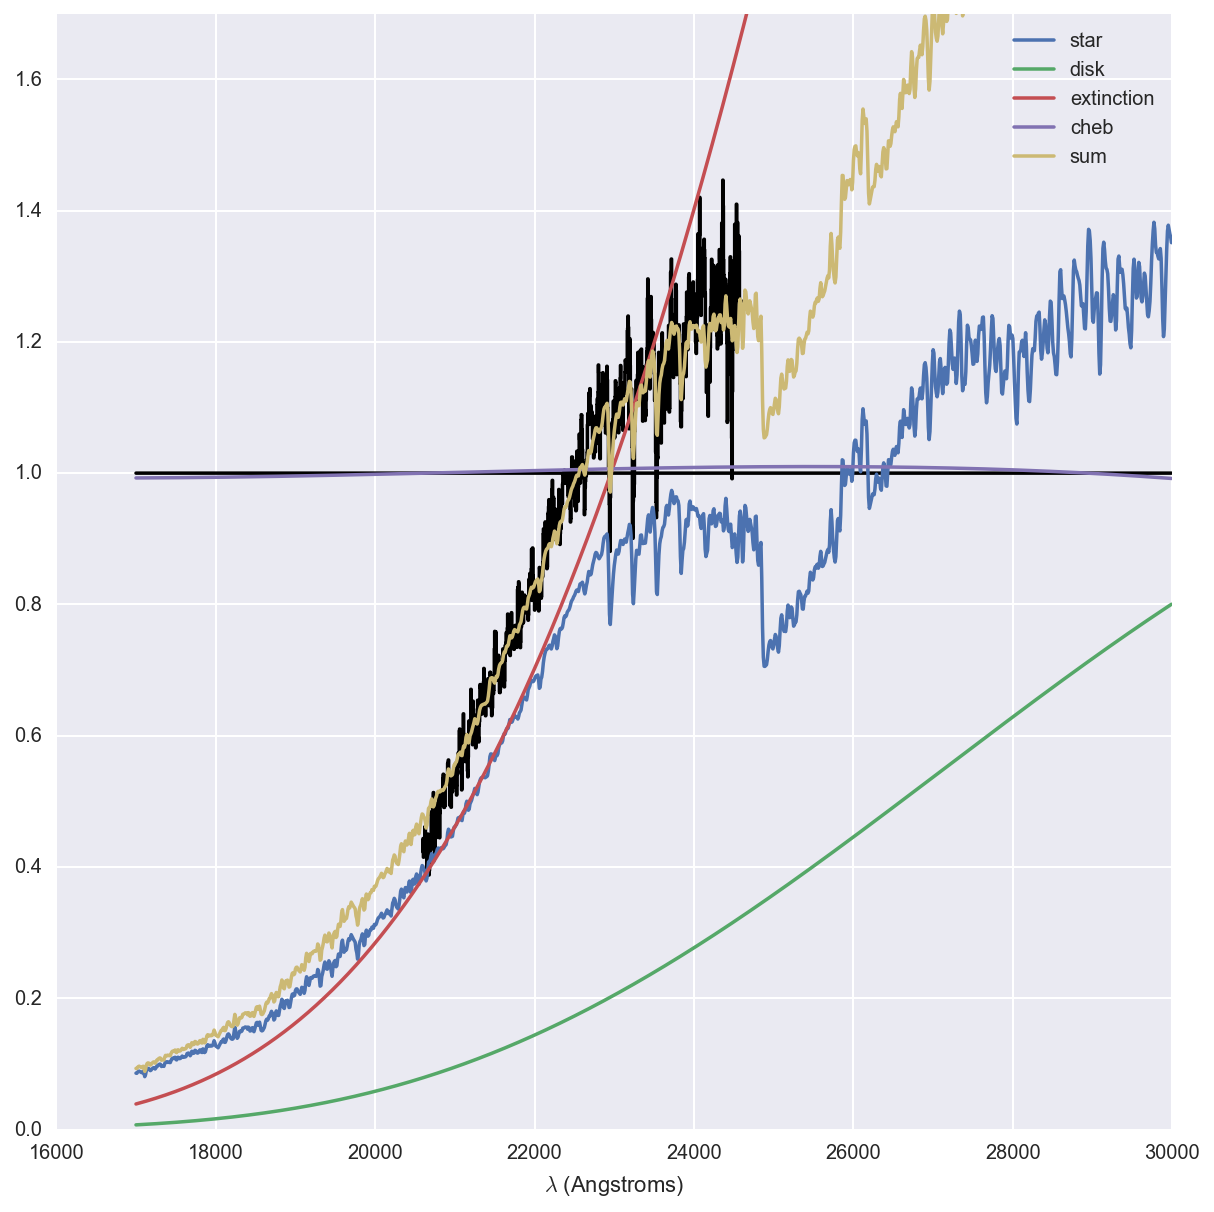

In [9]:
plt.figure(figsize=(10, 10))
plt.step(wl, fl, 'k')
plt.step(wl2, fl2, 'k')
plt.plot(wl, star, label = 'star')
plt.plot(wl, disk, label = 'disk')
plt.plot(wl, extinc, label = 'extinction')
plt.plot(wl, cheb, label = 'cheb')
plt.plot(wl, star+disk, label = 'sum')
plt.xlabel('$\lambda$ (Angstroms)')
plt.legend(loc='best')
plt.ylim(0, 1.7)

There's a shift because we divide the extinction by its mean!  This is not desired...

Load the noise model:

In [10]:
CC = np.load('../sf/exp11/output/jwst_simulation/run01/CC_new.npy')

In [11]:
net_model = star+disk

In [12]:
white_noise = np.median(net_model)/100.0

In [13]:
from scipy.stats import multivariate_normal

In [14]:
CC_diag = np.diagflat(white_noise**2)

In [15]:
nz_draw_d = multivariate_normal(net_model, CC_diag)

In [16]:
nz_draw = multivariate_normal(net_model, CC)

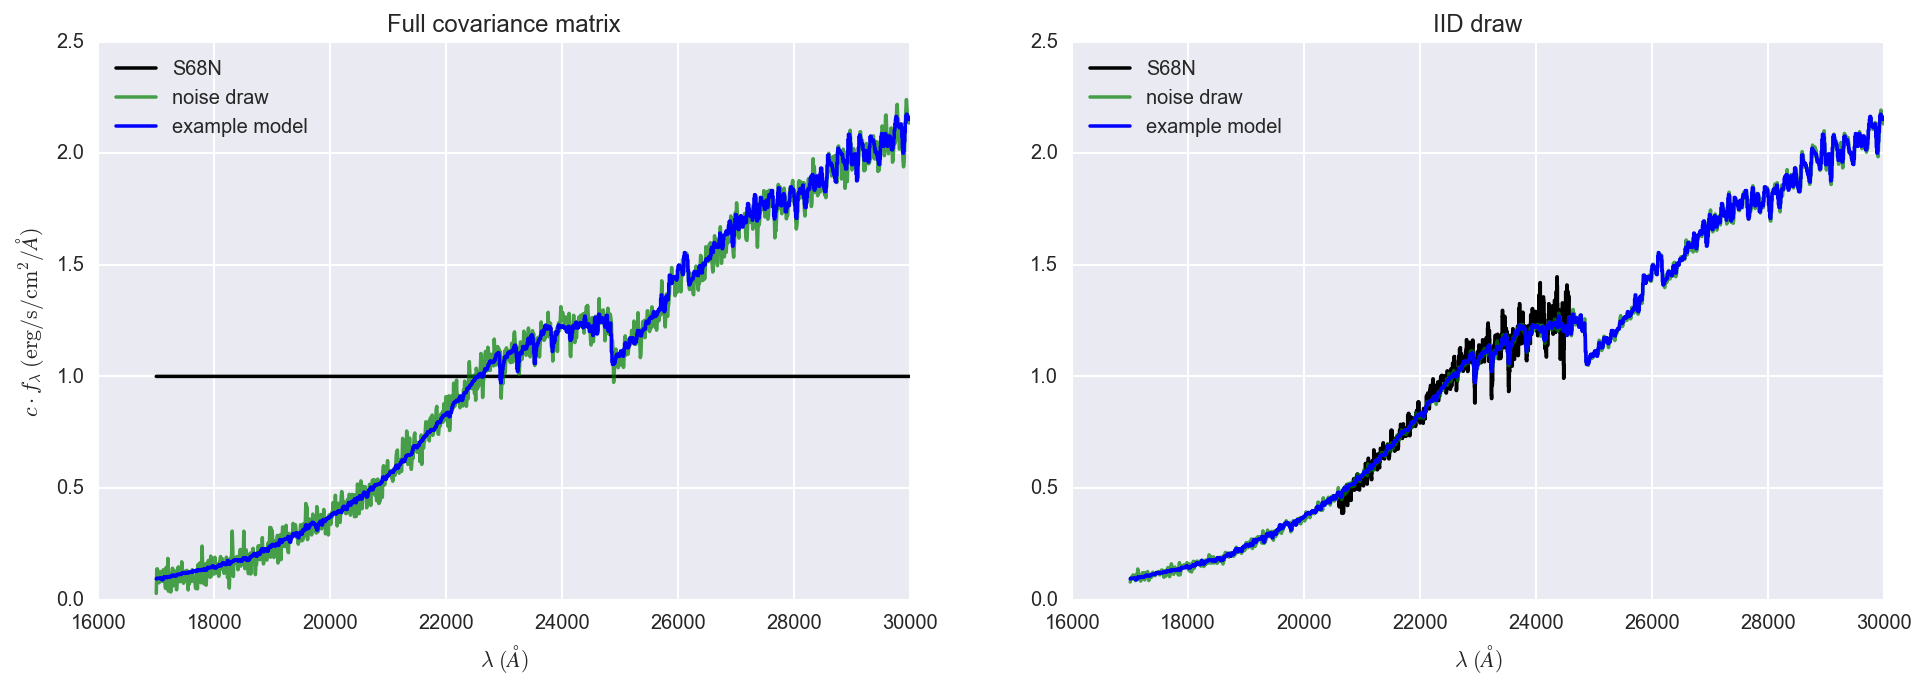

In [17]:
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.step(wl, fl, 'k', label='S68N')
plt.plot(wl, nz_draw.rvs(), 'g-', alpha=0.7, label='noise draw')
plt.step(wl, net_model, 'b', label='example model')

plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('$c\cdot f_\lambda \;(\mathrm{erg/s/cm}^2/\AA)$ ')
plt.title('Full covariance matrix')
plt.legend(loc='best')
plt.ylim(0, 2.5)

plt.subplot(122)
plt.step(wl2, fl2, 'k', label='S68N')
plt.plot(wl, nz_draw_d.rvs(), 'g-', alpha=0.7, label='noise draw')
plt.step(wl, net_model, 'b', label='example model')

plt.xlabel('$\lambda \;(\AA)$')
plt.title('IID draw')
plt.legend(loc='best')
plt.ylim(0, 2.5)

plt.yscale('linear')

# Make a figure for the paper

In [18]:
sns.set_context('paper')
sns.set_style('ticks')

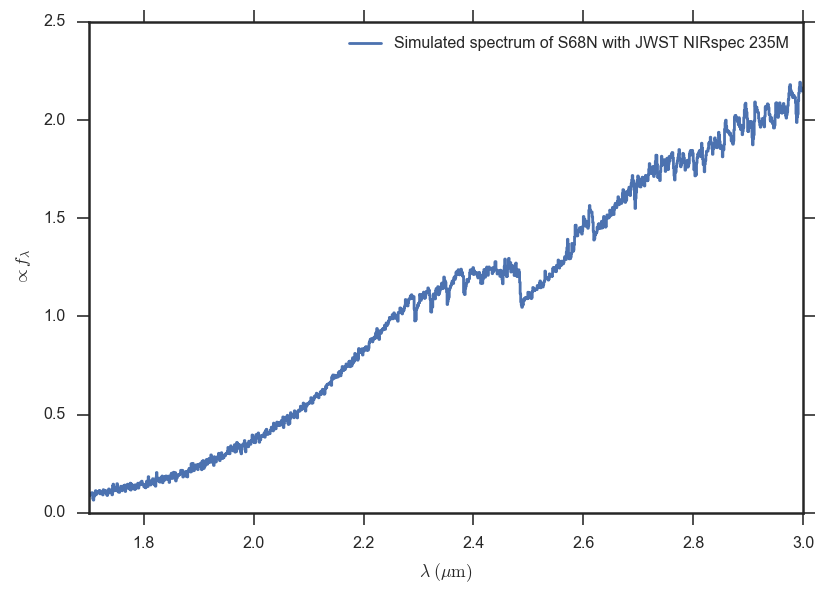

In [28]:
plt.step(wl/10000, nz_draw_d.rvs(), alpha=1.0, label='Simulated spectrum of S68N with JWST NIRspec 235M')
#plt.step(wl, net_model, 'b', label='example model')

plt.xlabel('$\lambda \;(\mu \mathrm{m})$')
plt.ylabel('$\propto f_\lambda$')
plt.legend(loc='best')
plt.ylim(0, 2.5)
plt.xlim(1.7, 3.0)
plt.yscale('linear')
plt.savefig('../document/figures/simulated_JWST_S68N.pdf', bbox_inches='tight')

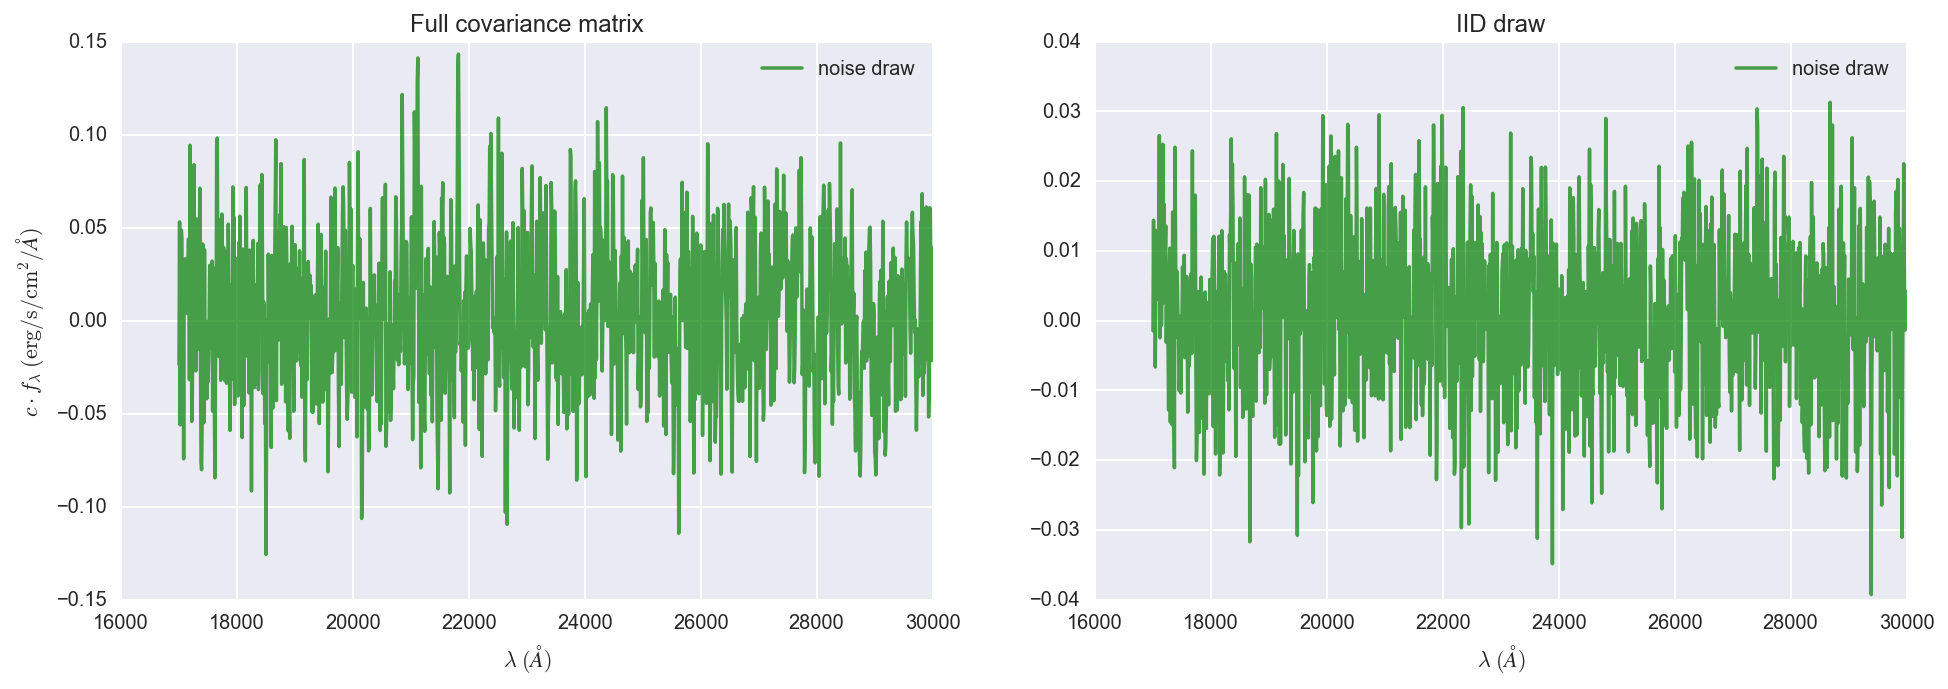

In [60]:
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(wl, nz_draw.rvs()-net_model, 'g-', alpha=0.7, label='noise draw')

plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('$c\cdot f_\lambda \;(\mathrm{erg/s/cm}^2/\AA)$ ')
plt.title('Full covariance matrix')
plt.legend(loc='best')
#plt.ylim(0, 2.5)

plt.subplot(122)
plt.plot(wl, nz_draw_d.rvs()-net_model, 'g-', alpha=0.7, label='noise draw')

plt.xlabel('$\lambda \;(\AA)$')
plt.title('IID draw')
plt.legend(loc='best')
#plt.ylim(0, 2.5)

plt.yscale('linear')

Let's verify the stellar parameters that generated this synthetic data:

In [61]:
ws = np.load('../sf/exp11/output/jwst_simulation/run01/emcee_chain.npy')

In [65]:
w = ws[0, 0, :]

In [72]:
w

array([  3.17796629e+03,   3.20744191e+00,   1.05703733e-02,
         1.11652768e+02,   2.94973030e+03,  -4.64350289e+00,
         1.40122887e+03,  -4.03087858e+00,   4.82089016e+00,
        -1.94445840e+00,   3.05699014e-03,  -7.72323731e-03,
        -3.45649936e-03,   3.73991987e-02,  -1.41302724e+00,
         1.06097936e+02])

In [71]:
print("Teff: {:4.0f} \nlogg: {:1.2f}".format(w[0], w[1]))

Teff: 3178 
logg: 3.21
